<strong>Description of project</strong>  <br>
Use the bike sharing dataset (`./bike_sharing/bike_hour.csv`, check `./bike_sharing/Readme.txt` for the description), apply the ML steps and gain insights from the data. What data transformations should be applied? Which attributes are most predictive? What additional attributes can be introduced? Which regression model performs best?

# Step 1: Import & inspect

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 

In [3]:
bike = pd.read_csv('./bike_sharing/bike_hour.csv')

In [4]:
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01/01/11,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01/01/11,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01/01/11,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01/01/11,spring,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01/01/11,spring,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(2)
memory usage: 2.3+ MB


##### There are no missing values

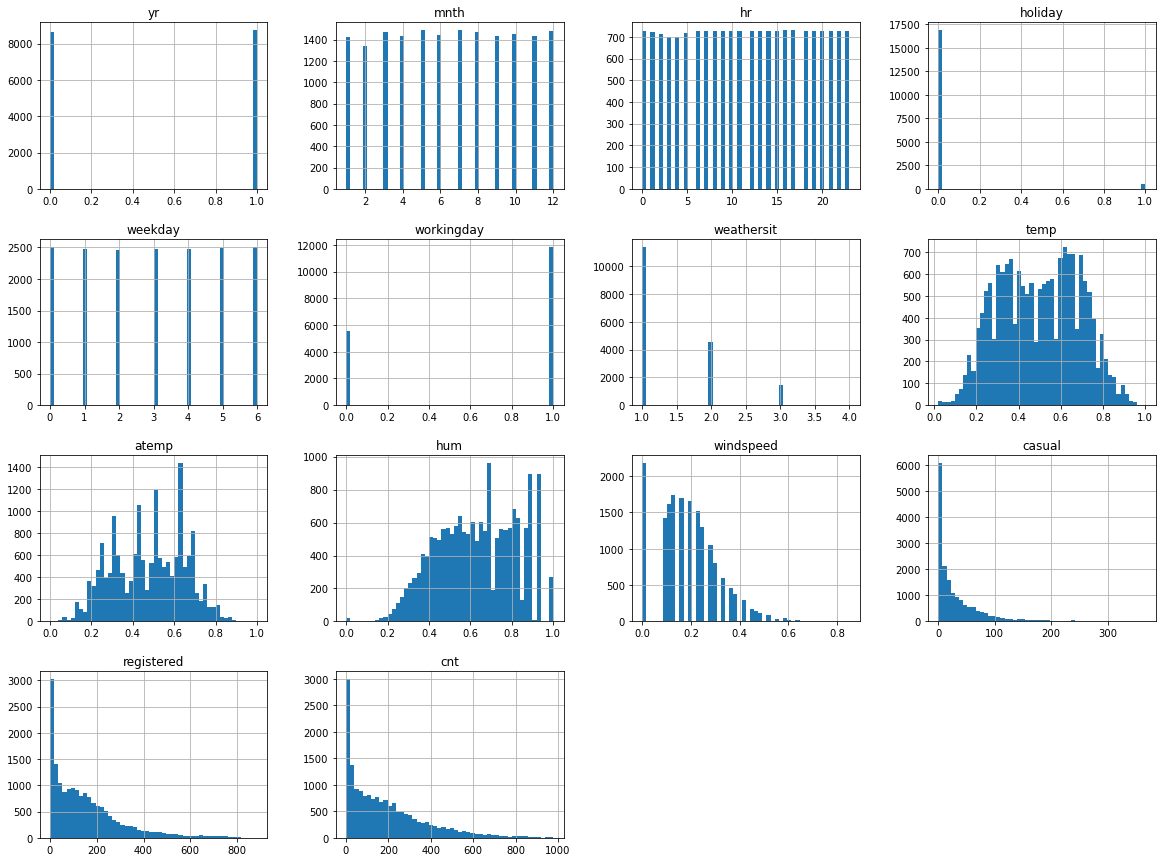

In [6]:
bike.iloc[:,3:].hist(figsize=(20,15), bins=50)
plt.show()

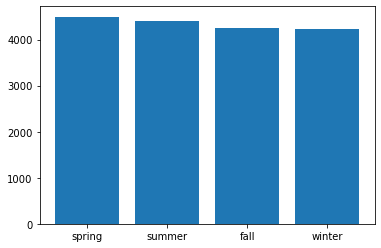

In [7]:
plt.bar(bike.season.unique(), bike.season.value_counts())
plt.show()

So we have a roughly equal amount of seasonal observations: stratification on the seasons is not necessary.<br>
The same goes for the month feature.

The registered vs casual users are not predictor variables. We could further apply a binary classification model to predict whether a user is causual or registered. We'll leave this more complicated task for later.

# Step 2: Splitting into training and test sets

Our prior belief is that climate conditions (and hence also seasonality) will affect the user count. We observe that the some climate condition observations are highly uneven in frequency, and therefore will introduce a strong bias if care is not take to stratify the test and train sets. The `weekend` and `holiday` columns can be merged together by binning the *weekend* column into binary weekend and non-weekend features. We could call the column `weekend` with values 0 for a day from Mon to Fri and 1 for either Sat or Sun.  This is already captured by the `workingday`. In doing this, we advance the belief that the the sole predictor category of the label is whether people are at work or at home (if it's Sunday but not a holiday people will be at home from work - we assume that Saturday is also a home day; this is reasonable in the US, where the data was sampled). This might not be true (during an extended holiday some people might leave the city, leaving a reduced number of potential bike sharing customers). We shall not pursue this investigation here in favour of keeping the analysis simple enough to make it a machine learning exercise. We leave the option open of refining the analysis in this direction in the future. We will, however, give a mathematical preview of how to optimally tacke the problem.<br>
<br>
We could use both `weekend` and `holiday` features and in addition to the `workingday` column with 1 for people at home (weekend == 1 or holiday==1) and 0 for people at work (workday == 0 and holiday == 0). The problem here is that keeping all three columns will introduce confounded features, i.e. the three feature vectors will be linearly dependent (this will not really be a problem as far as fitting and predicting with linear regression is concerned, but it might cause problems in the interpretation of the coefficients found by the optimization algorithm). This happens becuse the two features already span a 2 dimesional vector space. Here is a proof:<br>
A holiday can be either a workday (mwaning here opposite of weekend day) or not, and similarly for a non holiday.
Write basis vectors for workdays as $w_1 \rightarrow \text{ workday}$ and $w_2 \rightarrow \text{ weekend}$. Write $ h_1 \rightarrow \text{ not a holiday}$ and $ h_2 \rightarrow \text{ holiday}$. Then

\begin{align*}
h_1 = \alpha w_1 + \beta w_2 \qquad h_2 = \gamma w_1 + \delta w_2 \, .
\end{align*}
where  $\alpha = 0 \iff \beta = 1$ and similarly for $\gamma$ and $\delta$. A certain sample vector will be for instance, 
$$ v = w_1 + h_1 = (1+\alpha)w_1 + \beta w_2 \, .$$
In this case, $\beta = 0$, but that's beside the point here; the point is that every such vector is manifestly nonzero, thus provimg linear independence of the two features (workingday and holiday). Note that a more elegant description would be to take two Bernouilli random variables $X \in \{1,0\}$ and $Y \in \{0, 1\}$ for workingday and holiday respectively and write
\begin{align*}
h_1 = \mathbb{P}(X=0|Y=0) w_1 + \mathbb{P}(X=1|Y=0) w_2 \\
h_2 = \mathbb{P}(X=0|Y=1) w_1 + \mathbb{P}(X=1|Y=1) w_2 \, .
\end{align*}
<br><br>
Our discussion here shows incidentally that the sum of these two features (which correspond to what we called $v$ for a certain sample above) which will give us the column expressing whether or not people are at home that day is well defined (if it were the sum of a linearly dependent set of vectors, it would carry no intrinsic meaning as the features in the sum would not be independent of each other).

In [8]:
bike.weathersit.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

Let's make a copy for further exploration

Here is what it makes sense to stratify on (in order of increasing importance - higher importance means a larger difference among the observation categories or ranges):
- weathersit
- workingday 

As a further exploration it maight further make sense to create bins for windspeed, temp, and atemp.

In [9]:
bike.iloc[:, 4:].corr()

,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
mnth,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,0.208096,0.133750,-0.030973,-0.008821,0.054667,-0.105563,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929
hum,0.164411,-0.276498,-0.010588,-0.037158,0.015688,0.418130,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.322911
windspeed,-0.135386,0.137252,0.003988,0.011502,-0.011830,0.026226,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,0.093234


Note the strong correlation between temp and atemp. This might imply a relation of stron dependence of these two features might be convenient where one is to fit a linear regression model to the data. This is because linear regression assumes little or no collinearity among features [1]. We shall hereby make this choice.

In [10]:
bike.iloc[:, 4:].corr().cnt.sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Note the almost perfectly equal correltion with `temp` and `atemp` confirming their mutual dependence. The very high correlation with `registered` and `casual` is because their sum is perfecly predictive. We shall ignore these two column in our exploration, as anticipated above. If they are almost perfectly independent, then one of them is already predictive, and it doesn't therefore affect other learning algorithms.

We would now like to stratify on the combined classes of `weathersit` and `workingday`. The problem is that stratification does not work 'out of the box' in this particular case, since it turns out that we end up with a single instance belonging to the least populated class: for stratification we need at least two instances per classes. Let's look into this.

In [11]:
#classes = np.array([(x,y) for x, y in np.c_[bike.weathersit.values, bike.workingday.values]])

df = pd.DataFrame(data=[str((x,y)) for x,y in zip(bike.weathersit, bike.workingday)],
                  columns=['a'])
df

,a
0,"(1, 0)"
1,"(1, 0)"
2,"(1, 0)"
3,"(1, 0)"
4,"(1, 0)"
...,...
17374,"(2, 1)"
17375,"(2, 1)"
17376,"(1, 1)"
17377,"(1, 1)"


In [12]:
df.a.value_counts()

(1, 1)    7632
(1, 0)    3781
(2, 1)    3191
(2, 0)    1353
(3, 1)    1040
(3, 0)     379
(4, 1)       2
(4, 0)       1
Name: a, dtype: int64

We have a single instance for (4,0) \[extreme weather event on a working day\] and two observations in class (4,1) \[extreme weather event on a holiday\]. It would be sensible to bin these two classs together; holiday or not, one is rather unlikely to go for a bike ride during a thunderstorm. in other words, it's safe to assume that the fact that a certain day is a holiday or not is unlikely to influence one's decistion (not) to rent a bike during an extreme weather event. The problem comes down to how to practically label the classes. One option is to use string dtypes as above. Summing the integere entries of the tuples is not an option, since for instance $2+1 = 3+0 = 3$. Multiplication doesn't work either, because of the 0. Of course we could recast all numbers as primes so as to have different multiplication results for each class, and that's fine for this case, but we are interested in finding a method that scales and generalises to other problems. The string format seems to be the most convenient option.<br>
Let's start by adding the DataFrame df above to our bike dataset.

In [13]:
bike['classes'] = df.a

In [14]:
# strings are tricky, so let's verify that the strings in the format we intend to reproduce them are indeed 
# in the column

'(4, 0)' in bike.classes.values # and do the same for the other

True

In [15]:
update = bike.classes.replace(to_replace=['(4, 0)', '(4, 1)'], value='4')

In [16]:
update.unique() # yep, we're good

array(['(1, 0)', '(2, 0)', '(3, 0)', '(1, 1)', '(2, 1)', '(3, 1)', '4'],
      dtype=object)

In [17]:
del update

In [18]:
bike.classes.replace(to_replace=['(4, 0)', '(4, 1)'], value='4', inplace=True)

Now we can stratify to get train and test sets

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
# split method returns a generator, so either we call next on the return or we iterate through it
for train_index, test_index in splitter.split(bike, bike.classes):
    train_set, test_set = bike.loc[train_index], bike.loc[test_index]

In [20]:
print(train_set.shape, test_set.shape)

(13903, 18) (3476, 18)


In [21]:
def get_prop():
    df = pd.DataFrame({
        'original': bike.classes.value_counts()/len(bike),
        'train': train_set.classes.value_counts()/len(train_set),
        'test': test_set.classes.value_counts()/len(test_set),
        'train % error': 100*(train_set.classes.value_counts()/len(train_set)-bike.classes.value_counts()/len(bike)),
        'test % error': 100*(test_set.classes.value_counts()/len(test_set) - bike.classes.value_counts()/len(bike)),
    })
    
    return df
    

In [22]:
get_prop()

,original,train,test,train % error,test % error
"(1, 1)",0.439151,0.439186,0.439010,0.003509,-0.014034
"(1, 0)",0.217561,0.217579,0.217491,0.001752,-0.007006
"(2, 1)",0.183612,0.183629,0.183544,0.001703,-0.006810
"(2, 0)",0.077853,0.077825,0.077963,-0.002765,0.011060
"(3, 1)",0.059842,0.059843,0.059839,0.000086,-0.000344
"(3, 0)",0.021808,0.021794,0.021864,-0.001407,0.005628
4,0.000173,0.000144,0.000288,-0.002877,0.011506


<strong>Nice!</strong>

Since we want to keep the original dataset object unspoiled, we either drop the classes column or reimport it. We shall now work exclusively on the train set to avoid data leakage. We keep the classes column because it is also a predictor.

# Step 3: exploring the attributes

It's now time for some visualisation. Let's work on a copy of our training set to experiment on it. We decided that we should drop the following columns:
- casual
- registered
- weekday
- holiday
- atemp
- yr

We assume that two consecutive years do not contribute to any nonrandom variation of bike rentals, in other words all variations are noise that will skew the model and affect it's predictive power. Note that realistically, while this is a perfectly semsible assumption, it should be checked on historical data; for example it might be that the following year marks a period of recession during which people decide to cut their overall spending, or it might be marked by a sensibilisation campaign towards environment friendly practices.

In [23]:
bike = train_set.drop(labels=['casual', 'registered', 'weekday', 'holiday', 'atemp', 'yr'], axis=1)


By looking at the correlation matrix we notice a strong correlation of `cnt` with
- `temp`
- `hum`
- `hr`
- `weathersit`

which suggests that these features will be the most predictive. Hence We shall then plot these against `cnt` to get a feel of the relationship between them.<br>
We noticed in the further exploration of the first practical (housing prices in California dataset) that omitting less predictive features from the model decreases its scoring in terms of a highre RMSE. We shall therefore keep all features remaining in the train set from now on.

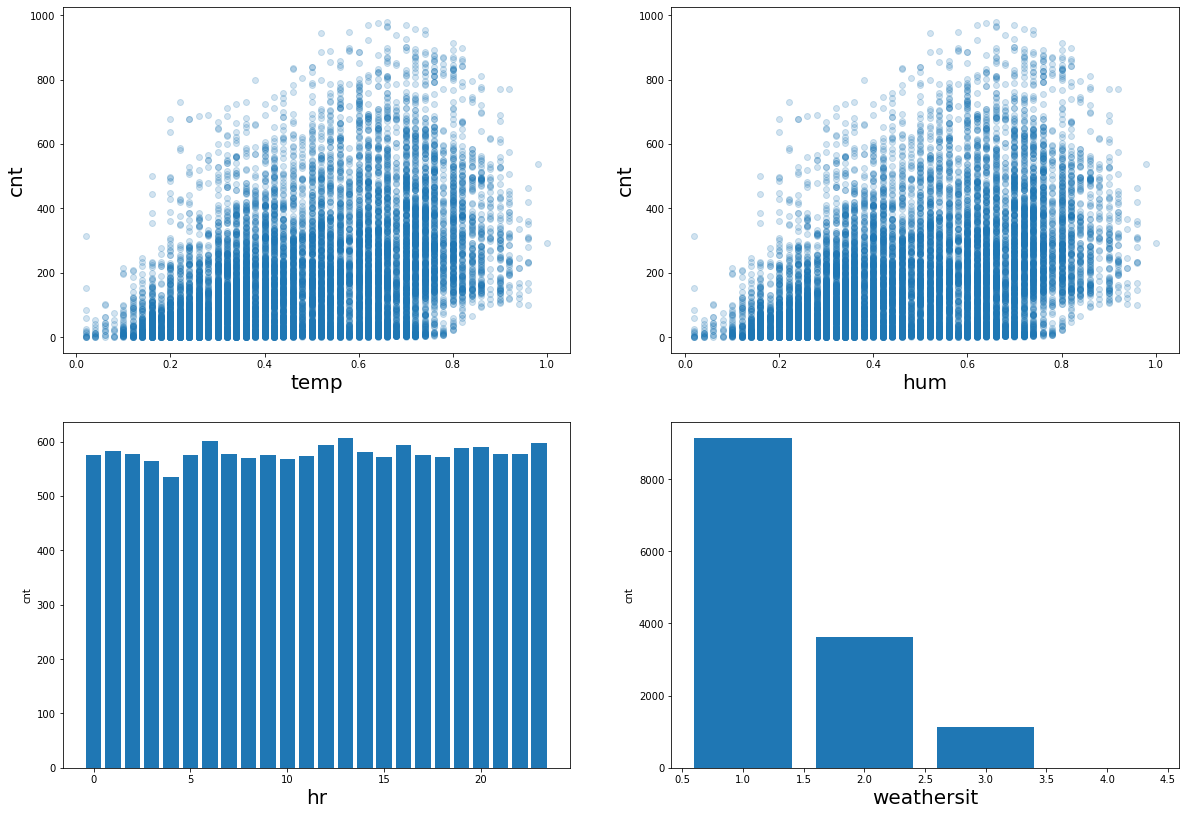

In [24]:
# use scatter for continuous features and bar for discrete ones

fig, axs = plt.subplots(2, 2, figsize=(20, 14))
feature_cts =  [bike.temp, bike.hum]
feat_name_cts = ['temp', 'hum']
for i in range(2):
        axs[0][i].scatter(feature_cts[0], bike.cnt, alpha=.2)
        axs[0][i].set_xlabel(feat_name_cts[i], size=20)
        axs[0][i].set_ylabel('cnt', size=20)

# we don't lose any reference; we delete list objects, not the names they refer to.
del i, feat_name_cts, feature_cts

feature_dsc = [bike.hr, bike.weathersit]
feat_name_dsc = ['hr', 'weathersit']
for j in range(2):
    axs[1][j].bar(x=sorted(feature_dsc[j].unique()),
                  height=pd.concat([feature_dsc[j],
                                    bike.cnt], axis=1).groupby(feat_name_dsc[j]).count().sort_index().values.reshape(-1))
    #index is already sorted by calling the method count(), but just to be explicit
    axs[1][j].set_xlabel(feat_name_dsc[j], size=20)
    axs[1][j].set_ylabel('cnt')

#del j, feat_name_dsc, feature_dsc

plt.show()

The plots on the first row are not very informative. What we can do is to aggreagate the `cnt` by temperature values using the mean

In [25]:
df1, df2 = train_set.loc[:, ['temp', 'cnt']].groupby('temp').mean(), train_set.loc[:, ['hum', 'cnt']].groupby('hum').mean()

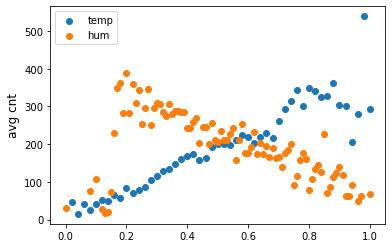

In [26]:
plt.scatter(x=df1.index, y=df1.cnt.values, label='temp')
plt.scatter(x=df2.index, y=df2.cnt.values, label='hum')
plt.ylabel('avg cnt', size=12)
plt.legend()
plt.show()

This is the trend that we would expect. As the temperature goes up, the number of users tend to increase because of the better climate conditions, whereas higher humidity is related to rain and as a consequences the average number of users tend to decrease. Note the outliers in the humidity scatter corresponding to very low values of humidity. This could be due to the fact that very low humidity is associated to high temperatures at which bike riding might also become unpleasant. This hypothesis seems to be confirmed by the seemengly decreasing trend after the peak of the temp scatter, save two outliers which might either be noise or might actually be related to certain particular events such as holidays. We will not, for now, explore these hypotheses further, concentrating instead on the technicalities of machine learning, but we leave the question open to an additional exploration in this direction for the future.

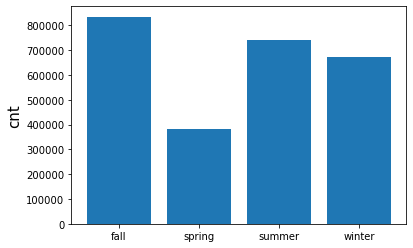

In [27]:
# There is also the season.

plt.bar(x=sorted(bike.season.unique()), height=bike.groupby('season').cnt.sum()) # total users per season
plt.ylabel('cnt', size=15)
plt.show()

# Step 4: Data preparation and transformation

In [28]:
bike = train_set.drop(labels=['casual', 'registered', 'weekday', 'holiday', 'atemp', 'yr', 'cnt', 'classes'],
                 axis=1)  # We drop the classes as we will use the independent features workingday and weathersit
bike_label = train_set.cnt.copy()

There are no missing value so we can skip considering any imputing strategy

__Categorical Attributes__

In [29]:
bike.head()

,instant,dteday,season,mnth,hr,workingday,weathersit,temp,hum,windspeed
353,354,16/01/11,spring,1,5,0,2,0.26,0.56,0.1642
118,119,06/01/11,spring,1,4,1,2,0.16,0.64,0.0896
10346,10347,12/03/12,spring,3,5,1,1,0.34,0.61,0.1940
11635,11636,05/05/12,summer,5,0,0,1,0.60,0.83,0.0000
1730,1731,17/03/11,spring,3,18,1,2,0.46,0.59,0.1642


The categorical featutures are the following:
- season
- mnth
- hr
- workingday
- weathersit
- dteday

In [30]:
bike.dteday.nunique()

730

Now, we could in principle create 730 categories for the `dteday` column, but it's likely that this would be overinformative and would result in an overfitting of the algorithm, which would then learn the single day data very well and would perform badly on new data with different days. In other words, it's unlikely that variation from one day to another would be significant in absence of noise, so we need some sort of binning. Taking only the month column will suffice, so we drop the `dteday` column. <br><br>

Also the `instant` carries no significance, so we drop it.

In [31]:
bike.drop(columns=['dteday', 'instant'], inplace=True)

In [32]:
bike.head()

,season,mnth,hr,workingday,weathersit,temp,hum,windspeed
353,spring,1,5,0,2,0.26,0.56,0.1642
118,spring,1,4,1,2,0.16,0.64,0.0896
10346,spring,3,5,1,1,0.34,0.61,0.1940
11635,summer,5,0,0,1,0.60,0.83,0.0000
1730,spring,3,18,1,2,0.46,0.59,0.1642


Temp and hum are already normalised, but not with z-score. That's what we will do. This will simply result in a shift and rescaling and will handle outliers well.

In [33]:
bike.temp.mean(), bike.temp.std(), bike.windspeed.mean(), bike.temp.std()

(0.49659641803927407,
 0.19233681406136877,
 0.1904102567791075,
 0.19233681406136877)

In [34]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline, FeatureUnion

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    """Utility class to separate numerical and categorical features to feed into different pipeline.
    
    It should be put at the top of the pipeline.
    """
    
    def __init__(self, feature_names):
        """
        feature_names:    iterable containing names of columns to be parsed as strings.
        """
        self._features = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self._features].values  # return a numpy.array
    
    
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    """Utility class to implement LabelBinarizer transformer into a pipeline (not supported as a Pipeline step)."""
    
    def __init__(self):
        self.encoder = LabelBinarizer()
    
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.encoder.transform(X)


In [36]:
num_attributes = ['temp', 'hum', 'windspeed']
cat_attributes = ['season', 'mnth', 'hr', 'workingday', 'weathersit']

num_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(num_attributes)),
    ('std_scaler', StandardScaler())
])

def binarize(feature):  #  it seems we have to binarize one column at a time, otherwise it doesn't work...
    cat_pipeline = Pipeline(steps=[
        ('selector', DataFrameSelector([feature])),
        ('binarizer', CustomLabelBinarizer())
    ])
    return cat_pipeline

full_pipeline = FeatureUnion(transformer_list=[('numerical', num_pipeline)]\
                             +[(f'categorical{cat_attributes.index(k)}', binarize(k)) for k in cat_attributes])

bike_prepared = full_pipeline.fit_transform(bike)
bike_prepared.shape

(13903, 48)

# Step 5: Evaluation, fine-tuning and testing

We begin by fitting a linear model

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def fit_regression(X, y, degree=1):
    if degree > 1:
        transformer = PolynomialFeatures(degree=degree)
        data = transformer.fit_transform(X)
    model = LinearRegression()
    model.fit(X, y)
    return model

def analyse_cv(model, *args, scoring='neg_mean_squared_error', cv=10):
    if len(args) != 2:
        raise NotImplementedError('Not Implemented: only parses two args')
    X, y = args
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    scores = np.sqrt(-scores)
    
    return f'RMSE:  {scores}\nMean:  {scores.mean()}\nStandard_deviation:  {scores.std()}\n'
    

In [38]:
for i in range(1,4):
    print(analyse_cv(fit_regression(bike_prepared, bike_label, degree=i), bike_prepared, bike_label))

RMSE:  [111.20110051 108.82028149 106.23587431 112.61824116 109.64045421
 108.56812692 108.47888964 114.92160462 108.82940022 114.7022919 ]
Mean:  110.40162649750155
Standard_deviation:  2.728415734761401

RMSE:  [111.20110051 108.82028149 106.23587431 112.61824116 109.64045421
 108.56812692 108.47888964 114.92160462 108.82940022 114.7022919 ]
Mean:  110.40162649750155
Standard_deviation:  2.728415734761401

RMSE:  [111.20110051 108.82028149 106.23587431 112.61824116 109.64045421
 108.56812692 108.47888964 114.92160462 108.82940022 114.7022919 ]
Mean:  110.40162649750155
Standard_deviation:  2.728415734761401



In [41]:
print(analyse_cv(fit_regression(bike_prepared, bike_label, degree=3), bike_prepared, bike_label))

RMSE:  [111.20110051 108.82028149 106.23587431 112.61824116 109.64045421
 108.56812692 108.47888964 114.92160462 108.82940022 114.7022919 ]
Mean:  110.40162649750155
Standard_deviation:  2.728415734761401



In [49]:
np.sqrt(-cross_val_score(model, bike_prepared, bike_label, scoring='neg_mean_squared_error', cv=10))

array([111.20110051, 108.82028149, 106.23587431, 112.61824116,
       109.64045421, 108.56812692, 108.47888964, 114.92160462,
       108.82940022, 114.7022919 ])

## Test

In [45]:
bike_test  = test_set.drop(labels=['casual', 'registered', 'weekday', 'holiday', 'atemp', 'yr', 'cnt', 'classes',
                                   'dteday','instant'], axis=1)
bike_test_label = test_set.cnt.copy()

bike_test_prepared = full_pipeline.fit_transform(bike_test)



In [51]:
print(analyse_cv(fit_regression(bike_prepared, bike_label, degree=1),
                 bike_test_prepared, bike_test_label))

RMSE:  [1.12403006e+02 1.14138835e+02 1.16121724e+02 1.08195981e+02
 1.14400918e+02 4.51615754e+12 1.06064923e+02 1.14605021e+02
 1.19894116e+02 1.02721479e+02]
Mean:  451615754451.71173
Standard_deviation:  1354847263018.953



In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# specify the range of hyperparameter values for the grid search to try out 
param_grid = {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")
grid_search.fit(bike_prepared, bike_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             scoring='neg_mean_squared_error')

In [50]:
final_model = grid_search.best_estimator_

In [53]:
bike_test  = test_set.drop(labels=['casual', 'registered', 'weekday', 'holiday', 'atemp', 'yr', 'cnt', 'classes',
                                   'dteday','instant'], axis=1)
bike_test_label = test_set.cnt.copy()

bike_test_prepared = full_pipeline.fit_transform(bike_test)

In [54]:
MSE = mean_squared_error(bike_test_label, final_model.predict(bike_test_prepared))
RMSE = np.sqrt(MSE)
print(RMSE)

76.35109721978493


## References

- [[1]](https://www.lexjansen.com/wuss/2018/130_Final_Paper_PDF.pdf) "_Logistic and Linear Regression Assumptions: Violation Recognition and Control_", Deanna Schreiber-Gregory, Henry M Jackson Foundation